<a href="https://colab.research.google.com/github/wdconinc/practical-computing-for-scientists/blob/master/Lectures/lecture17.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lecture #17

In [0]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import math
import numpy.matlib as ml

##In our last episode

* The _trapezoid rule_ and _extended trapezoid rule_
* Integration of 1D functions using _Quadrature_
 * Algorithm description
 * Implementation in code
 * Weird correction: $S = (4 S_{2N} - S_N)/3$ 
   * Related to _Simpson's rule_
   * Cancels $\mathcal{O}(h^2)$ truncation error
   * 1 - 2 orders of magnitude fewer function calls

# Numerical Integration

We approximate the integral
$$ I = \int_a^b f(x) dx $$
with a finite sum
$$ I_N = \sum_{i=0}^{n = 2^N} A_i f(x_i) $$
by evaluating the function at select points $x_i$.

Two approaches:
* Newton-Cotes quadrature, e.g. trapezoid rule, simpson rule: take equally spaced $x_i$, separated by $h_N = (b - a)/2^N$
  * requires many evaluations of $f(x)$ so mainly useful if $f(x)$ is inexpensive to calculate,
  * has issues with singularities in $f(x)$, even if there is a well-defined limit.
* Gaussian quadrature: take specific values for $x_i$ so we can reach the required precision most quickly
  * requires far fewer evaluations of $f(x)$,
  * can handle integrable singularities in $f(x)$.

## Quadrature using Newton-Cotes Methods

#### Cardinal functions as polynomial interpolation of order $n$

The cardinal functions $h_i(x)$ are polynomials of degree $n$ which are 1 for $x_i$ but 0 at all other $x_i$:
$$ h_i(x) = \prod_{j=0,\,j\ne i}^n \frac{x-x_j}{x_i-x_j} $$.

For degree $n = 0$ we 'interpolate' $f(x)$ around $x_0 = (a+b) / 2$ as
$$  f(x) \approx f(x_0) h_0(x) $$
with
$$ h_0(x) = 1 $$
such that
$$ f(x) \approx f\Big(\frac{a+b}{2}\Big) $$
This is a constant 'interpolation' (extrapolation) between $a$ and $b$.

For degree $n = 1$ we interpolate $f(x)$ between $x_0 = a$ and $x_1 = b$ as
$$ f(x) \approx f(x_0) h_0(x) + f(x_1) h_1(x) $$
with
$$ h_0(x) = \frac{x - x_1}{x_0 - x_1} = -(x-b)/h $$
$$ h_1(x) = \frac{x - x_0}{x_1 - x_0} = (x-a)/h $$
such that
$$ f(x) \approx -(x-b) f(a) / h + (x-a) f(b) / h $$
This is a linear interpolation between $a$ and $b$.

For degree $n = 2$ we interpolate $f(x)$ using $x_0 = a$, $x_1 = \frac{a+b}{2}$ and $x_2 = b$ with $h_i(x)$ which are now quadratic functions.

#### Newton-Cotes method
We approximate $f(x)$ as a piecewise constant polynomial of degree $n$ through all the nodes:
$$ f(x) \approx P_n(x) = \sum_{i=0}^n f(x_i) h_i(x) $$
with cardinal functions $h_i(x)$.

Then
$$ I = \int_a^b f(x) dx \approx \sum_{i=0}^n f(x_i) \int_a^b h_i(x) dx = \sum_{i=0}^n A_i f(x_i) $$
with
$$ A_i = \int_a^b h_i(x) dx $$
where we can calculate $A_i$ in advance.

#### Zeroth order (not used in practice)

For $n = 0$, $h_0(x)$ is just a constant which goes through $x_0 = \frac{a+b}{2}$ only:
$$ h_0(x) = f(\frac{a+b}{2}) $$
and we get 
$$ \int_a^b f(x) dx \approx h f\Big(\frac{a + b}{2}\Big) $$

If we use the extended method, we get a piecewise constant approximation.

<img src="https://upload.wikimedia.org/wikipedia/commons/2/26/Integration_rectangle.svg" width="500">

#### First order (Trapezoid rule)
For $n = 1$, $h_1(x)$ is a linear function which goes through $x_0 = 1$ and $x_1 = b$
$$ h_0(x) = \frac{x - x_1}{x_0 - x_1} = -(x-b)/h $$
$$ h_1(x) = \frac{x - x_0}{x_1 - x_0} = (x-a)/h $$
and we get the $A_i$:
$$ A_0 = -\int_a^b (x-b)/h dx = h/2 $$
$$ A_1 = \int_a^b (x-a)/h dx = h/2 $$
such that
$$ \int_a^b f(x) dx \approx h/2 \Big( f(a) + f(b) \Big) $$

If we use the extended method, we get a piecewise linear approximation.

<img src="https://upload.wikimedia.org/wikipedia/commons/4/40/Trapezoidal_rule_illustration.svg" width="300">

### Trapezoid Rule

The trapezoid rule calculates the integral over the interval $[a,b]$ as
$$\int_a^b f(x) dx \approx h(\frac{1}{2}f(a)+ \frac{1}{2}f(b)) $$
where $h=b-a$ is the length of the interval. 

### Extended Trapezoid Rule

The extended trapezoid rule just divides the interval $[a,b]$ into N sub-intervals and then employs the trapezoid rule in each:

$$ \int_a^b f(x) dx \approx h \left[ \frac{1}{2}f(x_0)+ f(x_1) + f(x_2) + \ldots + f(x_{N-1}) + \frac{1}{2}f(x_{N}) \right ] $$
where $h = (b-a)/N$ is the length of each sub-interval, $x_0 = a$, and $x_N = b$.

In [0]:
def quad(f, a, b, facc = 1e-6, abacc = 1e-10, nmax = 24, debug = False):
    ''' integrate the function f(x) on the interval [a,b]
    
        iterate until the fractional difference between successive calls is
        less than facc, the absolute difference is less than abacc
        or until nmax iterations have been reached.
        
        Has the Simpson correction.        
    '''
    # stage 1
    h = (b - a)
    Iold = 0.5 * (f(b) + f(a))
    Icorrold = 0.0
    for nstage in range(2, nmax+1):
        if debug: print("nstage =", nstage)
        h = (b - a) / 2**(nstage-1)
        xnew = a + h
        Iupdate = f(xnew)
        for inew in range(1, 2**(nstage-2)):
            xnew += 2*h
            Iupdate += f(xnew)
        Iupdate *= h
        Inew = 0.5*Iold + Iupdate
        Icorr = (4.0*Inew - Iold) / 3.0
        if debug: print(Iold, Iupdate, Inew, Icorr, Inew - Iold, facc * math.fabs(Iold))
        if math.fabs(Icorr - Icorrold) < facc * math.fabs(Icorrold) \
        or (math.fabs(Icorr) < abacc and math.fabs(Icorrold) < abacc):
            return Icorr, nstage
        Iold = Inew
        Icorrold = Icorr

In [0]:
f1 = lambda x: np.exp(-x)
print("Result %12.12g found in %i stages" % quad(f1, 0, 1))
print("Correct result =", 1 - math.e**(-1))

Result 0.632120562177 found in 6 stages
Correct result = 0.6321205588285577


In [0]:
import scipy.integrate as ig
print("Result %12.12g, estimated error %g" % ig.quad(f1, 0, 1))

Result 0.632120558829, estimated error 7.01795e-15


### Example: heat capacity


$$ C_V = 9 N k \, g(u) $$
where
$$ g(u) = u^3 \int_0^{1/u} \frac{x^4 e^x}{(e^x - 1)^2} dx $$
and $N$ the number of particles in the solid, $k = 1.38 \times 10^{-23}\,$J/K the Boltzman constant, $u = T/T_D$, $T$ the absolute temperature, and $T_D$ the Debye temperature. E.g. $T_D(\mbox{Cu}) = 343$ K

Plot the heat capacity as a function of temperature.

<img src="https://upload.wikimedia.org/wikipedia/commons/5/54/DebyeVSEinstein.jpg" width="500">

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


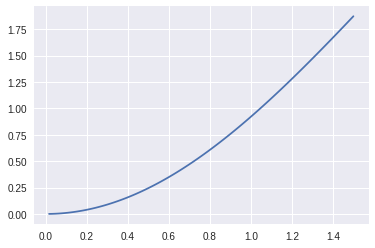

In [0]:
integrand = lambda x: x**4 * np.exp(x) / (np.exp(x) - 1)**2
x = np.linspace(0, 1.5, 100)

plt.plot(x, integrand(x))

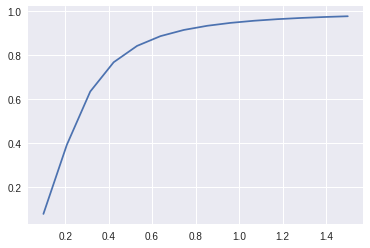

In [0]:
def CV(ulist, xmin = 1e-6):
  return [3 * u**3 * quad(integrand, xmin, 1.0 / u)[0] for u in ulist]

u = np.linspace(1e-6, 1.5, 14)
plt.plot(u, CV(u))

### Simpson Rule

Using the second order polynomial interpolation of $f(x)$ between $a$ and $b$, using points $x_0 = a$, $x_1 = \frac{a+b}{2}$, $x_2 = b$, we can obtain:
$$ A_0 = h / 3 $$
$$ A_1 = 4h / 3 $$
$$ A_2 = h / 3 $$
such that 
$$\int_a^b f(x) dx \approx \frac{h}{3} \Big(f(a) + 4 f\big(\frac{a+b}{2}\big) + f(b) \Big) $$


### Extended Simpson Rule

The extended Simpson rule just divides the interval $[a,b]$ into N (even) sub-intervals and then employs the Simpson rule in each:

$$ \int_a^b f(x) dx \approx \frac{h}{3} \left[ f(x_0)+ 4 f(x_1) + 2 f(x_2) + 4 f(x_3) + \ldots + 2 f(x_{N-2}) + 4 f(x_{N-1}) + f(x_{N}) \right ] $$
where $h = (b-a)/N$ is the length of each sub-interval, $x_0 = a$, and $x_N = b$.

Whereas the Trapezoid rule had a truncation error of $\mathcal{O}(h^2)$, the Simpson rule has a truncation error of $\mathcal{O}(h^4)$. We can also write a recursive Simpson rule which ends iteration when a specified accuracy has been reached.

## Gaussian Quadrature

Often we find that we need to calculate not merely the integral
$$ I_{unweighted} =\int_a^b f(x) dx $$
but the integral 
$$ I_{weighted} = \int_a^b w(x) f(x) dx $$
where $w(x)$ is a commonly recurring weighting function.

For example, you may be interested in
$$ \int_0^{+\infty} e^{-x} f(x) dx $$.

As in the case of Newton-Cotes, we want to approximate this integral as a sum
$$ I \approx \sum_{i=0}^n w_i f(x_i) $$
for a specific set of coefficients or 'weights' $\{w_i\}$ and unevently spaced abscissa or 'nodes' $\{x_i\}$. 

In Gaussian quadrature we determine the weights and nodes such that the integral is exact if the function is a polynomial $P_m(x)$ of degree $m$ less than $n + (n + 1) = 2n + 1$. These conditions become:
$$ \int_a^b w(x) P_m(x) dx = \sum_{i=0}^n w_i P_m(x_i) \quad \mbox{for\,} 0\le m \le 2n+1 $$
This means we need to solve the $2n+2$ equations
$$ \int_a^b w(x) x^m dx = \sum_{i=0}^n w_i x_i^m \quad \mbox{for\,} 0\le m \le 2n+1 $$




### Example for $w(x) = e^{-x}$ (Laguerre weighting function)

If $w(x) = e^{-x}$, $a = 0$, $b = +\infty$, and $n = 1$, then the equations are:
$$ \int_0^{+\infty} e^{-x} x^0 dx = w_0 x_0^0 + w_1 x_1^0 $$
$$ \int_0^{+\infty} e^{-x} x^1 dx = w_0 x_0^1 + w_1 x_1^1 $$
$$ \int_0^{+\infty} e^{-x} x^2 dx = w_0 x_0^2 + w_1 x_1^2 $$
$$ \int_0^{+\infty} e^{-x} x^3 dx = w_0 x_0^3 + w_1 x_1^3 $$

After determining the integrals we find:
$$ w_0 + w_1 = 1 $$
$$ w_0 x_0 + w_1 x_1 = 1 $$
$$ w_0 x_0^2 + w_1 x_1^2 = 2 $$
$$ w_0 x_0^3 + w_1 x_1^3 = 6 $$
which we can solve as
$$ x_0 = 2 - \sqrt{2} $$
$$ x_1 = 2 + \sqrt{2} $$
$$ w_0 = \frac{\sqrt{2} + 1}{2\sqrt{2}} $$
$$ w_1 = \frac{\sqrt{2} - 1}{2\sqrt{2}} $$
such that
$$ \int_0^{+\infty} e^{-x} f(x) dx \approx \frac{1}{2\sqrt{2}} \Big( (\sqrt{2}+1) f(2-\sqrt{2}) + (\sqrt{2} - 1) f(2 + \sqrt{2}) \Big) $$

Notice that the points are not equidistantly spaced!

Commonly used quadrature weighting functions:
* Legendre: $w(x) = 1$, $a = -1$, $b = +1$
* Chebyshev: $w(x) = \frac{1}{\sqrt{1-x^2}}$, $a = -1$, $b = +1$
* Laguerre: $w(x) = e^{-x}$, $a = 0$, $b = +\infty$
* Hermite: $w(x) = e^{-x^2}$, $a = -\infty$, $b = +\infty$

In general, the weighting function defines an orthogonal set of polynomials (e.g. Hermite polynomials associated with Hermite weighting function) such that
$$ \int_a^b w(x) P_m(x) P_n(x) dx = \delta_{mn} $$
where $m$ and $n$ are the orders of the polynomials.

The $n$ zeroes of the polynomial $P_n(x)$ will be the abscissa or nodes $x_i$.

### Gauss-Legendre Quadrature

Guass-Legendre quadrature is the case for
$$ I = \int_{-1}^{+1} f(x) dx \approx \sum_{i=0}^n w_i f(x_i) $$

For $n = 1$: what are the equations?

## Multi-dimensional integrals

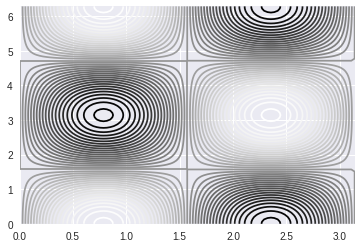

In [0]:
import scipy.special as sf
theta, phi = np.mgrid[0:math.pi:101j, 0:2*math.pi:101j]
n = 1
m = 2
Ynm = sf.sph_harm(n, m, phi, theta)
plt.contour(theta, phi, np.real(Ynm), 50)